# Applied Questions _ Chapter_8

In [2]:
import pandas as pd
import numpy as np

from sklearn.linear_model import Ridge,Lasso,LogisticRegression
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor
from sklearn.metrics import mean_squared_error,accuracy_score,confusion_matrix
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn import tree
from xgboost import XGBRegressor,XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

from tqdm import tqdm
import graphviz
from IPython.display import HTML

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## 7. In the lab, we applied random forests to the Boston data using mtry=6 and using ntree=25 and ntree=500. Create a plot displaying the test error resulting from random forests on this data set for a more comprehensive range of values for mtry and ntree. You can model your plot after Figure 8.10. Describe the results obtained




In [3]:
boston_data = load_boston()
boston = pd.DataFrame(boston_data['data'],columns=boston_data['feature_names'])
boston['MEDV'] = boston_data['target']
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


Before going any further, i consider a good practice to go through the data once, and see what the columns describe. 


- CRIM - per capita crime rate by town
- ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
- INDUS - proportion of non-retail business acres per town.
- CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
- NOX - nitric oxides concentration (parts per 10 million)
- RM - average number of rooms per dwelling
- AGE - proportion of owner-occupied units built prior to 1940
- DIS - weighted distances to five Boston employment centres
- RAD - index of accessibility to radial highways
- TAX - full-value property-tax rate per $10,000

- PTRATIO - pupil-teacher ratio by town
- B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
- LSTAT - % lower status of the population
- MEDV - Median value of owner-occupied homes in $1000's

In [4]:
#splitting the data into train and test 
X_train,X_test,y_train,y_test = train_test_split(boston.drop('MEDV',axis=1),boston['MEDV'],test_size = 0.5,)

In [5]:
p = boston.drop('MEDV',axis = 1).shape[1] # total number of features
max_features_dict = {'p':p,'p/2':int(p/2),'sqrt(p)':int(np.sqrt(p))} # or we can also use keywords like 'auto','sqrt'
scores_dict = {}

randomforestregressor - https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
We would be focussing on two paramters - n_estimators and max_features

In [6]:
from tqdm import tqdm
scores_dict = {}
for max_feature_value in ['p','p/2','sqrt(p)']:
  max_feat = max_features_dict[max_feature_value]
  scores = []
  for n_estimator in tqdm(range(1,501,10)):
    rf = RandomForestRegressor(n_estimators=n_estimator,max_features=max_feat)
    rf.fit(X_train,y_train)
    scores.append(mean_squared_error(y_test,rf.predict(X_test)))
  scores_dict[max_feature_value] = scores

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.29it/s]


In [7]:
scores_dict.keys()

dict_keys(['p', 'p/2', 'sqrt(p)'])

In [8]:
df = pd.DataFrame(scores_dict)
df.index = np.arange(1,501,10)

Text(0, 0.5, 'Test MSE')

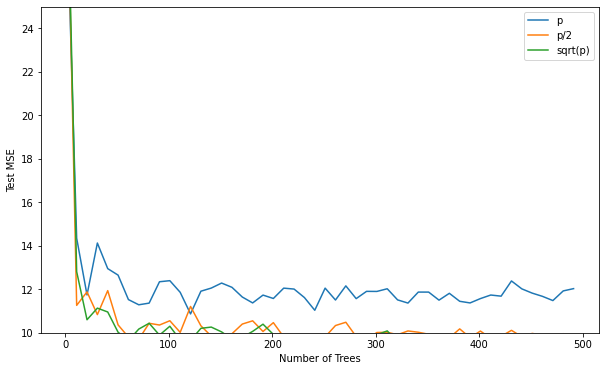

In [9]:
df.plot(figsize = (10,6))
plt.ylim(10,25)
plt.xlabel('Number of Trees')
plt.ylabel('Test MSE')

## 8. In the lab, a classification tree was applied to the Carseats data set after converting Sales into a qualitative response variable. Now we will seek to predict Sales using regression trees and related approaches, treating the response as a quantitative variable



In [11]:
carseats = pd.read_csv(r'./data/Carseats.csv')
print(carseats.shape)
carseats.head()

(400, 11)


,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


( Optional )
Going through the data columns - 
- Sales: unit sales in thousands
- CompPrice: price charged by competitor at each location
- Income: community income level in 1000s of dollars
- Advertising: local ad budget at each location in 1000s of dollars
- Population: regional pop in thousands
- Price: price for car seats at each site
- ShelveLoc: Bad, Good or Medium indicates quality of shelving location
- Age: age level of the population
- Education: ed level at location
- Urban: Yes/No
- US: Yes/No

In [12]:
data = carseats.copy()
# as the labels are ordinal, we would only be using label encoder, and since the values are small in number, we will map them
yes_no_dict = {'Yes':1,'No':0}
data['Urban'] = data['Urban'].map(yes_no_dict)
data['US'] = data['US'].map(yes_no_dict)
data['ShelveLoc'] = data['ShelveLoc'].map({'Bad':0,'Good':1,'Medium':3})

In [13]:
data.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,0,42,17,1,1
1,11.22,111,48,16,260,83,1,65,10,1,1
2,10.06,113,35,10,269,80,3,59,12,1,1
3,7.40,117,100,4,466,97,3,55,14,1,1
4,4.15,141,64,3,340,128,0,38,13,1,0


### (a) Split the data set into a training set and a test set.

In [14]:
X_train,X_test,y_train,y_test = train_test_split(data.drop('Sales',axis= 1),data['Sales'],test_size = 0.5,random_state = 1)
print(X_train.shape,X_test.shape)

(200, 10) (200, 10)


### (b) Fit a regression tree to the training set. Plot the tree, and interpret the results. What test MSE do you obtain?

In [15]:
model = DecisionTreeRegressor()
model.fit(X_train,y_train)
print('Training MSE is ',mean_squared_error(y_train,model.predict(X_train))) 
## what the hell, its surely overfitting, lets now plot the tree and caclulate the test mse

Training MSE is  0.0


In [17]:
#plotting the tree
import os
# https://graphviz.org/download/ --> goto install Graphviz for your Operating System(OS), 
# not only ' pip install graphviz ' graphviz for python package.
os.environ["PATH"] += os.pathsep + "D:/miniconda/Graphviz/bin/"

dot_data = tree.export_graphviz(model, out_file=None, feature_names=X_train.columns, filled=True)
# Draw graph
graph = graphviz.Source(dot_data) 
display(HTML(graph._repr_svg_()))

The above tree is a very very complex tree, that is because i didn;t specified any max_depth. normally optimal max_depth ranges from 3-6, so, will have to see that

In [18]:
#test mse 
print('Test MSE is ',mean_squared_error(y_test,model.predict(X_test)))
print('Test R2 score is ',model.score(X_test,y_test)) # it is pretty poor

Test MSE is  5.7523575000000005
Test R2 score is  0.24637277971282312


### (c) Use cross-validation in order to determine the optimal level of tree complexity. Does pruning the tree improve the test MSE?


In [22]:
scores_dict = {}
for max_depth in range(1,10):
  model = DecisionTreeRegressor(max_depth=max_depth)
  scores_dict[max_depth] = -np.mean(cross_val_score(model,X_train,y_train,scoring = 'neg_mean_squared_error',cv=10))

Text(0, 0.5, '10 CV Error')

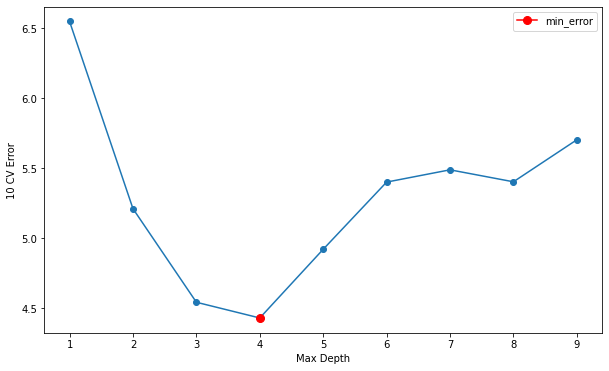

In [23]:
plt.figure(figsize = (10,6))
plt.plot(list(scores_dict.keys()),list(scores_dict.values()),marker = 'o')
plt.plot(min(scores_dict, key=scores_dict.get),min(list(scores_dict.values())),marker = 'o',markersize = 8,c='r',label = 'min_error')
plt.legend()
plt.xlabel('Max Depth')
plt.ylabel('10 CV Error')

In [24]:
# from the above graph, we get 4 as the best value of max_depth
best_model = DecisionTreeRegressor(max_depth = 4)
best_model.fit(X_train,y_train)
print('Training MSE is ',mean_squared_error(y_train,best_model.predict(X_train)))
print('Test MSE is ',mean_squared_error(y_test,best_model.predict(X_test)))

Training MSE is  2.2486282645877234
Test MSE is  4.871934165478578


Test MSE has decreases from 5.41834 to 4.82. That's great!

### Lets analyze this tree

In [25]:
#plotting the tree

dot_data = tree.export_graphviz(best_model, out_file=None, feature_names=X_train.columns, filled=True)
# Draw graph
graph = graphviz.Source(dot_data) 
display(HTML(graph._repr_svg_()))

<AxesSubplot:>

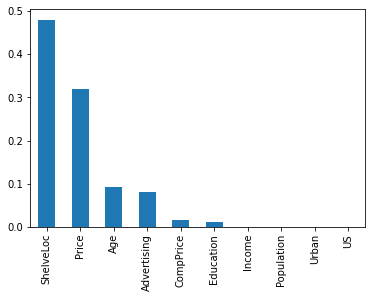

In [26]:
# feature importance for best model
pd.Series(best_model.feature_importances_,index = X_train.columns).sort_values(ascending=False).plot.bar()

From the above graph it is clear that Shelveloc and Price are the most important features to detect the price. So, if someone is starting a new store, just make sure the shelveLoc is Good!

### (d) Use the bagging approach in order to analyze this data. What test MSE do you obtain? Use the importance() function to determine which variables are most important.


In [27]:
base_reg = DecisionTreeRegressor()
bagging = BaggingRegressor(base_reg)
bagging.fit(X_train,y_train)
print('Training MSE ',mean_squared_error(y_train,bagging.predict(X_train)))
print('Test MSE ',mean_squared_error(y_test,bagging.predict(X_test)))

Training MSE  0.55785651
Test MSE  3.1267753299999996


Using bagging we are getting a significant decrease in MSE to 1.15

<AxesSubplot:>

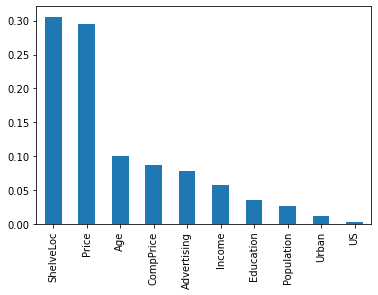

In [28]:
# going through each of the estimator in bagging model to calculate feature importance
feature_importances = np.mean([tree.feature_importances_ for tree in bagging.estimators_], axis=0)
pd.Series(feature_importances,index = X_train.columns).sort_values(ascending=False).plot.bar()

Unlike the decision tree regressor, bagging model gives similar importance to ShelveLoc and Price, infact here importnace of Price is slightly greater than ShelveLoc. So, if someone is starting a new store, we would suggest - "hey buddy, keep the condition of ShelveLoc good, but keep the price reasonable too" :D

### (e) Use random forests to analyze this data. What test MSE do you obtain? Use the importance() function to determine which variables are most important. Describe the effect of m, the number of variables considered at each split, on the error rate obtained.




In [29]:
rf = RandomForestRegressor()
rf.fit(X_train,y_train)
print('Training MSE is ',mean_squared_error(y_train,rf.predict(X_train)))
print('Test MSE is ',mean_squared_error(y_test,rf.predict(X_test)))

Training MSE is  0.3859495991999995
Test MSE is  2.8498077087999985


Woah, random forest further decreases MSE to 2.968

<AxesSubplot:>

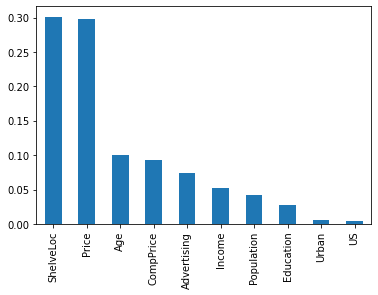

In [30]:
#feature importance
pd.Series(rf.feature_importances_,index = X_train.columns).sort_values(ascending=False).plot.bar()

We can see that the feature importance plot is quite similar to the one we got from bagging model. 

### Effect of max_features (m)

In [31]:
scores_dict = {}
for max_feature_value in range(1,11):
  rf = RandomForestRegressor(max_features=max_feature_value)
  rf.fit(X_train,y_train)
  scores_dict[max_feature_value] = mean_squared_error(y_test,rf.predict(X_test))

Text(0, 0.5, 'Test Error')

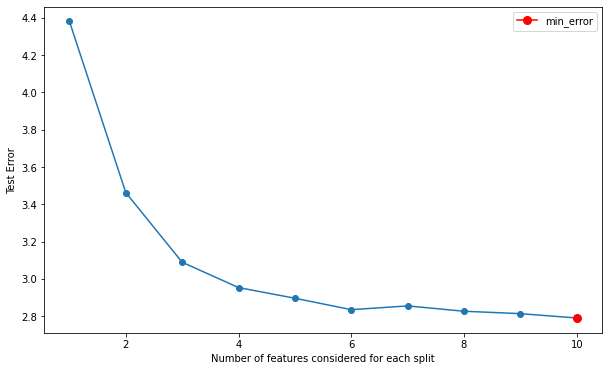

In [32]:
plt.figure(figsize = (10,6))
plt.plot(list(scores_dict.keys()),list(scores_dict.values()),marker = 'o')
plt.plot(min(scores_dict, key=scores_dict.get),min(list(scores_dict.values())),marker = 'o',markersize = 8,c='r',label = 'min_error')
plt.legend()
plt.xlabel('Number of features considered for each split')
plt.ylabel('Test Error')

We are getting best value when the value of the parameter is 7.

## 9. This problem involves the OJ data set which is part of the ISLR package.



In [35]:
data = pd.read_csv(r'./data/OJ.csv',index_col=0)
print(data.shape)
data.head()

(1070, 18)


,Purchase,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,Store7,PctDiscMM,PctDiscCH,ListPriceDiff,STORE
1,CH,237,1,1.75,1.99,0.00,0.0,0,0,0.500000,1.99,1.75,0.24,No,0.000000,0.000000,0.24,1
2,CH,239,1,1.75,1.99,0.00,0.3,0,1,0.600000,1.69,1.75,-0.06,No,0.150754,0.000000,0.24,1
3,CH,245,1,1.86,2.09,0.17,0.0,0,0,0.680000,2.09,1.69,0.40,No,0.000000,0.091398,0.23,1
4,MM,227,1,1.69,1.69,0.00,0.0,0,0,0.400000,1.69,1.69,0.00,No,0.000000,0.000000,0.00,1
5,CH,228,7,1.69,1.69,0.00,0.0,0,0,0.956535,1.69,1.69,0.00,Yes,0.000000,0.000000,0.00,0


Lets go through the dataset, and see what it describes
- Purchase-A factor with levels CH and MM indicating whether the customer purchased Citrus Hill or Minute Maid Orange Juice

- WeekofPurchase - Week of purchase
- StoreID-Store ID
- PriceCH-Price charged for CH
- PriceMM-Price charged for MM
- DiscCH-Discount offered for CH
- DiscMM-Discount offered for MM
- SpecialCH-Indicator of special on CH
- SpecialMM-Indicator of special on MM
- LoyalCH-Customer brand loyalty for CH
- SalePriceMM-Sale price for MM
- SalePriceCH-Sale price for CH
- PriceDiff-Sale price of MM less sale price of CH
- Store7-A factor with levels No and Yes indicating whether the sale is at Store 7
- PctDiscMM-Percentage discount for MM
- PctDiscCH-Percentage discount for CH
- ListPriceDiff-List price of MM less list price of CH
- STORE-Which of 5 possible stores the sale occured at

In [36]:
data['Purchase'].value_counts()

CH    653
MM    417
Name: Purchase, dtype: int64

We can guess from the dataset, that the problem we are having involves a number of predictors, and we want to predict whether a customer will go for CH(citrus hill), or mm(minute maid)

In [37]:
#encoding the categorical columns
data['Purchase'] = data['Purchase'].map({'CH':0,'MM':1})
data['Store7'] = data['Store7'].map({'Yes':1,'No':0})
data.head()

,Purchase,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,Store7,PctDiscMM,PctDiscCH,ListPriceDiff,STORE
1,0,237,1,1.75,1.99,0.00,0.0,0,0,0.500000,1.99,1.75,0.24,0,0.000000,0.000000,0.24,1
2,0,239,1,1.75,1.99,0.00,0.3,0,1,0.600000,1.69,1.75,-0.06,0,0.150754,0.000000,0.24,1
3,0,245,1,1.86,2.09,0.17,0.0,0,0,0.680000,2.09,1.69,0.40,0,0.000000,0.091398,0.23,1
4,1,227,1,1.69,1.69,0.00,0.0,0,0,0.400000,1.69,1.69,0.00,0,0.000000,0.000000,0.00,1
5,0,228,7,1.69,1.69,0.00,0.0,0,0,0.956535,1.69,1.69,0.00,1,0.000000,0.000000,0.00,0


### (a) Create a training set containing a random sample of 800 observations, and a test set containing the remaining observations.

In [38]:
X_train,X_test,y_train,y_test = train_test_split(data.drop('Purchase',axis=1),data['Purchase'],test_size = 0.2523,random_state=1)
print(X_train.shape,X_test.shape)
#i have used test_size = 270 / 1070, such that training data has 800 observations

(800, 17) (270, 17)


### (b) Fit a tree to the training data, with Purchase as the response and the other variables except for Buy as predictors. Use the summary() function to produce summary statistics about the tree, and describe the results obtained. What is the training error rate? How many terminal nodes does the tree have?


 


In [39]:
model = DecisionTreeClassifier()
model.fit(X_train,y_train)
print('Training Error rate ',1 - model.score(X_train,y_train))

Training Error rate  0.010000000000000009


One thing i have observed is that if we don;t specify any max_depth, or any other parameter that acts like a stopping condition, the tree is most likely to overfit, looking at the training error here, it seems to be the same.

### (c) Type in the name of the tree object in order to get a detailed text output. Pick one of the terminal nodes, and interpret the information displayed.


In [40]:
# this is the closest i can find
print(tree.export_text(model))

|--- feature_8 <= 0.45
|   |--- feature_8 <= 0.28
|   |   |--- feature_8 <= 0.05
|   |   |   |--- feature_1 <= 2.50
|   |   |   |   |--- feature_8 <= 0.00
|   |   |   |   |   |--- feature_0 <= 269.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- feature_0 >  269.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- feature_8 >  0.00
|   |   |   |   |   |--- class: 1
|   |   |   |--- feature_1 >  2.50
|   |   |   |   |--- class: 1
|   |   |--- feature_8 >  0.05
|   |   |   |--- feature_0 <= 249.50
|   |   |   |   |--- feature_16 <= 1.50
|   |   |   |   |   |--- feature_0 <= 235.50
|   |   |   |   |   |   |--- feature_0 <= 232.00
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- feature_0 >  232.00
|   |   |   |   |   |   |   |--- feature_6 <= 0.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- feature_6 >  0.50
|   |   |   |   |   |   |   |   |--- feature_0 <= 233.50
|   |   |   |   |   |   |   |   |   |--- cl

### (d) Create a plot of the tree, and interpret the results.

In [41]:
#plotting the tree

dot_data = tree.export_graphviz(model, out_file=None, 
                                feature_names=X_train.columns,  
                                filled=True)
# Draw graph
graph = graphviz.Source(dot_data) 
display(HTML(graph._repr_svg_()))

One thing i can surely say is that this tree is too complex, and we would favour simpler tree than that (OCCAM's RAZOR)

### (e) Predict the response on the test data, and produce a confusion matrix comparing the test labels to the predicted test labels. What is the test error rate?



In [42]:
y_preds = model.predict(X_test)
print('Test error is ',1 - accuracy_score(y_test,y_preds))

Test error is  0.2407407407407407


In [43]:
#confusion matrix 
cm = confusion_matrix(y_test,y_preds)
pd.DataFrame(cm,columns = ['Pred_0','Pred_2'],index = ['True_0','True_1'])

,Pred_0,Pred_2
True_0,134,23
True_1,42,71


### (g) Produce a plot with tree size on the x-axis and cross-validated classification error rate on the y-axis.


In [44]:
cv_scores_dict = {}
for max_depth in range(1,15):
    model = DecisionTreeClassifier(max_depth=max_depth)
    cv_scores_dict[max_depth] = 1 - np.mean(cross_val_score(model,X_train,y_train,cv = 10))

In [45]:
plt.plot

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

Text(0, 0.5, '10 CV Error')

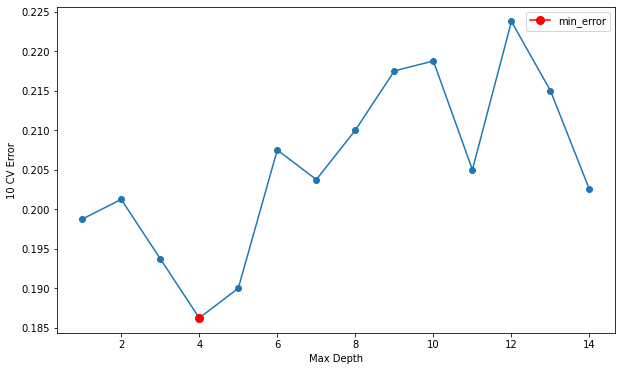

In [46]:
plt.figure(figsize = (10,6))
plt.plot(list(cv_scores_dict.keys()),list(cv_scores_dict.values()),marker = 'o')
plt.plot(min(cv_scores_dict, key=cv_scores_dict.get),min(list(cv_scores_dict.values())),marker = 'o',markersize = 8,c='r',label = 'min_error')
plt.legend()
plt.xlabel('Max Depth')
plt.ylabel('10 CV Error')

### (h) Which tree size corresponds to the lowest cross-validated classification error rate?

Tree with max_depth = 4, is giving the minimum cv error.

In [47]:
best_model = DecisionTreeClassifier(max_depth = 4)
best_model.fit(X_train,y_train)
dot_data = tree.export_graphviz(best_model, out_file=None, 
                                feature_names=X_train.columns,  
                                filled=True)
# Draw graph
graph = graphviz.Source(dot_data) 
display(HTML(graph._repr_svg_()))

This looks simple and elegent

### (i) Produce a pruned tree corresponding to the optimal tree size obtained using cross-validation. If cross-validation does not lead to selection of a pruned tree, then create a pruned tree with five terminal nodes.




In [48]:
# pruned tree with 5 terminal nodes
pruned_tree = DecisionTreeClassifier(max_leaf_nodes=5)
pruned_tree.fit(X_train,y_train)
dot_data = tree.export_graphviz(pruned_tree, out_file=None, 
                                feature_names=X_train.columns,  
                                filled=True)
# Draw graph
graph = graphviz.Source(dot_data) 
display(HTML(graph._repr_svg_()))

In [49]:
unpruned_tree = DecisionTreeClassifier()
unpruned_tree.fit(X_train,y_train)

DecisionTreeClassifier()

### (j) Compare the training error rates between the pruned and unpruned trees. Which is higher?

In [50]:
print('Training error for pruned ',np.round(1 - (pruned_tree.score(X_train,y_train)),4))
print('Training error for unpruned ',np.round(1 - (unpruned_tree.score(X_train,y_train)),4))

Training error for pruned  0.165
Training error for unpruned  0.01


### (k) Compare the test error rates between the pruned and unpruned trees. Which is higher?


In [51]:
print('Test error for pruned ',np.round(1 - (pruned_tree.score(X_test,y_test)),4))
print('Test error for unpruned ',np.round(1 - (unpruned_tree.score(X_test,y_test)),4))

Test error for pruned  0.1815
Test error for unpruned  0.237


From the above results, it can be seen that the unpruned tree is highly overfitting

## 10. We now use boosting to predict Salary in the Hitters data set.

In [53]:
data = pd.read_csv(r'./data/Hitters.csv')
data = data.iloc[:,1:] #removing the first col, which contains names
print(data.shape)
data.head()

(322, 20)


,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [54]:
#lets check for cat columns
cat = [col for col in data.columns if data[col].dtype == 'O']
for col in cat:
    print(col)
    print(data[col].value_counts())
    print()

League
A    175
N    147
Name: League, dtype: int64

Division
W    165
E    157
Name: Division, dtype: int64

NewLeague
A    176
N    146
Name: NewLeague, dtype: int64



In [55]:
# encoding the cat cols 
data['League'] = data['League'].map({'A':0,'N':1})
data['Division'] = data['Division'].map({'W':0,'E':1})
data['NewLeague'] =  data['NewLeague'].map({'A':0,'N':1})

Now we have all the cols in numerics 

### (a) Remove the observations for whom the salary information is unknown, and then log-transform the salaries


In [56]:
# removing the null values (only the salary col has null values)
data.dropna(inplace = True)

#log_transforming the salaries 
data['Salary_log'] = np.log(data['Salary'])

In [57]:
# how does the data looks like now!!
print(data.shape)
data.head()

(263, 21)


,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,...,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague,Salary_log
1,315,81,7,24,38,39,14,3449,835,69,...,414,375,1,0,632,43,10,475.0,1,6.163315
2,479,130,18,66,72,76,3,1624,457,63,...,266,263,0,0,880,82,14,480.0,0,6.173786
3,496,141,20,65,78,37,11,5628,1575,225,...,838,354,1,1,200,11,3,500.0,1,6.214608
4,321,87,10,39,42,30,2,396,101,12,...,46,33,1,1,805,40,4,91.5,1,4.516339
5,594,169,4,74,51,35,11,4408,1133,19,...,336,194,0,0,282,421,25,750.0,0,6.620073


It must be tiring to hear this now, but i request you to go throught the whole of the dataset. Like what it describes, what are each of the columns, and how this could be useful. (This is what matters in the end)

### (b) Create a training set consisting of the first 200 observations, and a test set consisting of the remaining observations.


In [58]:
X_train,X_test,y_train,y_test = train_test_split(data.drop(['Salary','Salary_log'],axis = 1),data['Salary_log'],
                                                    test_size = 0.239,random_state = 1)
#test_size = 63 / 253
print(X_train.shape,X_test.shape)

(200, 19) (63, 19)


### (c) Perform boosting on the training set with 1,000 trees for a range of values of the shrinkage parameter λ. Produce a plot with different shrinkage values on the x-axis and the corresponding training set MSE on the y-axis.




In [61]:
# we are going to use XGboost here, we saw in the labs that XGboost performs better than Adaboost
scores_dict_train = {}
scores_dict_test = {}
gamma_values = np.linspace(0,1,50)
for gamma in (gamma_values):
  xgb = XGBRegressor(n_estimators=1000,gamma=gamma)
  xgb.fit(X_train,y_train)
  scores_dict_train[gamma] = mean_squared_error(y_train,xgb.predict(X_train))
  scores_dict_test[gamma] = mean_squared_error(y_test,xgb.predict(X_test))

Text(0, 0.5, 'Training Error')

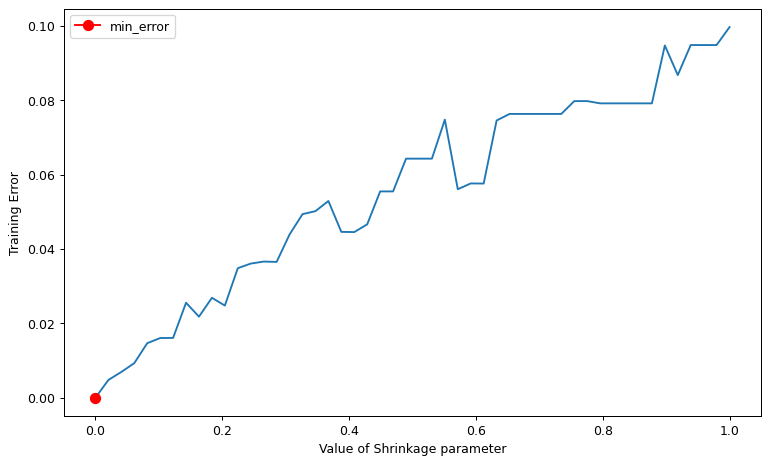

In [63]:
plt.figure(figsize = (10,6), dpi=90)
plt.plot(list(scores_dict_train.keys()),list(scores_dict_train.values()))
plt.plot(min(scores_dict_train, key=scores_dict_train.get),min(list(scores_dict_train.values())),marker = 'o',markersize = 8,c='r',label = 'min_error')
plt.legend()
plt.xlabel('Value of Shrinkage parameter')
plt.ylabel('Training Error')

### (d) Produce a plot with different shrinkage values on the x-axis and the corresponding test set MSE on the y-axis.


Text(0, 0.5, 'Test Error')

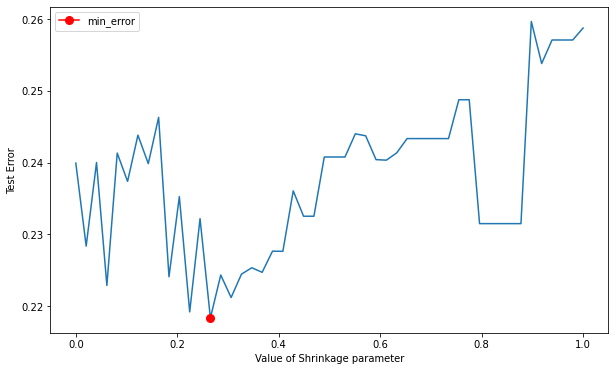

In [64]:
plt.figure(figsize = (10,6)) 
plt.plot(list(scores_dict_test.keys()),list(scores_dict_test.values()))
plt.plot(min(scores_dict_test, key=scores_dict_test.get),min(list(scores_dict_test.values())),marker = 'o',markersize = 8,c='r',label = 'min_error')
plt.legend()
plt.xlabel('Value of Shrinkage parameter')
plt.ylabel('Test Error')

The value of test mse is min when value of shrinkage paramter is 0.326

### (e) Compare the test MSE of boosting to the test MSE that results from applying two of the regression approaches seen in Chapters 3 and 6.



### Ridge


In [66]:
scores_dict_ridge = {}
list_alpha = 10**np.linspace(-2,5,100)
for alpha in list_alpha:
  model = Ridge(alpha=alpha) 
  model.fit(X_train,y_train)
  scores_dict_ridge[alpha] = mean_squared_error(y_test,model.predict(X_test))

### Lasso

In [67]:
scores_dict_lasso = {}
list_alpha = 10**np.linspace(-2,5,100)
for alpha in list_alpha:
  model = Lasso(alpha=alpha) 
  model.fit(X_train,y_train)
  scores_dict_lasso[alpha] = mean_squared_error(y_test,model.predict(X_test))

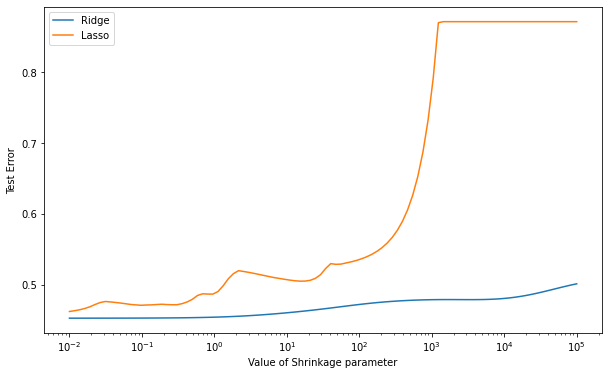

In [68]:
plt.figure(figsize = (10,6)) 
plt.plot(list(scores_dict_ridge.keys()),list(scores_dict_ridge.values()),label = 'Ridge')
plt.plot(list(scores_dict_lasso.keys()),list(scores_dict_lasso.values()),label = 'Lasso')
plt.legend()
plt.xlabel('Value of Shrinkage parameter')
plt.ylabel('Test Error')
plt.xscale('log')

In [69]:
# lets find out the best test mse value for both the cases 
print('Best test MSE for RIdge is ',min(scores_dict_ridge.values()))
print('Best test MSE for LASSO is ',min(scores_dict_lasso.values()))

Best test MSE for RIdge is  0.4526550397946482
Best test MSE for LASSO is  0.4621250353318539


HMMMM, very close to each other

In [70]:
# what was the best test MSE for boosting 
print('Best TEST MSE for Boosting is ',min(scores_dict_test.values()))

Best TEST MSE for Boosting is  0.2183315948375049


We can see that boosting outperforms the other methods..(BY A MILE)

### (f) Which variables appear to be the most important predictors in the boosted model?


In [71]:
best_boosting_model = XGBRegressor(n_estimators=1000,gamma=0.326)
best_boosting_model.fit(X_train,y_train)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.326, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=16, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Text(0.5, 1.0, 'Feature Importance')

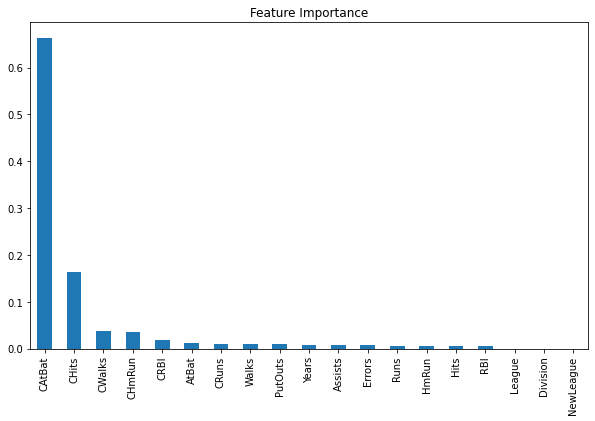

In [72]:
# feature importance
pd.Series(best_boosting_model.feature_importances_,index = X_train.columns).sort_values(ascending=False).plot.bar(figsize = (10,6))
plt.title('Feature Importance')

The three features CatBat, Chits, Cruns, are the most important features to determine Salary

### (g) Now apply bagging to the training set. What is the test set MSE for this approach?


In [73]:
base_reg = DecisionTreeRegressor()
bagging = BaggingRegressor(base_reg)
bagging.fit(X_train,y_train)
print('Training MSE ',mean_squared_error(y_train,bagging.predict(X_train)))
print('Test MSE ',mean_squared_error(y_test,bagging.predict(X_test)))

Training MSE  0.040199825564986025
Test MSE  0.2856771112425551


It gives Test MSE of 0.28, which is close but not better than the MSE we got from Boosting, which was 0.22

### 11. This question uses the Caravan data set.

In [75]:
data = pd.read_csv(r'./data/Caravan.csv')
print(data.shape)
data = data.iloc[:,1:] #removing the first col
data.head()

(5822, 87)


,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,Purchase
0,33,1,3,2,8,0,5,1,3,7,...,0,0,0,1,0,0,0,0,0,No
1,37,1,2,2,8,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,No
2,37,1,2,2,8,0,4,2,4,3,...,0,0,0,1,0,0,0,0,0,No
3,9,1,3,3,3,2,3,2,4,5,...,0,0,0,1,0,0,0,0,0,No
4,40,1,4,2,10,1,4,1,4,7,...,0,0,0,1,0,0,0,0,0,No


In [76]:
# lets check for any cat values
[col for col in data.columns if data[col].dtype == 'O']

['Purchase']

Only the response value is categorical, which is Yes or No, lets encode it then

In [77]:
data['Purchase'] = data['Purchase'].map({'Yes':1,'No':0})

### (a) Create a training set consisting of the first 1,000 observations, and a test set consisting of the remaining observations.


In [78]:
train_data = data.iloc[:1000,:]
X_train = train_data.drop('Purchase',axis = 1)
y_train = train_data['Purchase']

test_data = data.iloc[1000:,:]
X_test = test_data.drop('Purchase',axis = 1)
y_test = test_data['Purchase']

print(X_train.shape,X_test.shape)

(1000, 85) (4822, 85)


### (b) Fit a boosting model to the training set with Purchase as the response and the other variables as predictors. Use 1,000 trees, and a shrinkage value of 0.01. Which predictors appear to be the most important?




In [79]:
model = XGBClassifier(n_estimators=1000,gamma=0.01)
model.fit(X_train,y_train)
print('Training score ',model.score(X_train,y_train))

[18:05:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training score  0.995


Text(0.5, 1.0, 'Top 10 important features')

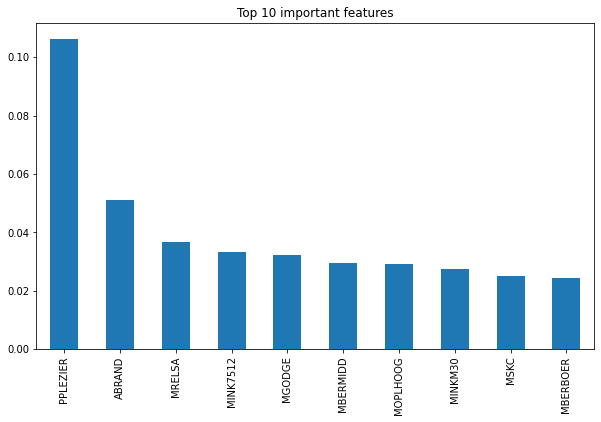

In [80]:
# feature importance
pd.Series(model.feature_importances_,index = X_train.columns).sort_values(ascending=False)[:10].plot.bar(figsize = (10,6))
plt.title('Top 10 important features')

Above are the 10 most important features

### (c) Use the boosting model to predict the response on the test data. Predict that a person will make a purchase if the estimated probability of purchase is greater than 20 %. Form a confusion matrix. What fraction of the people predicted to make a purchase do in fact make one? How does this compare with the results obtained from applying KNN or logistic regression to this data set?





In [81]:
print('Test Accuracy is ', model.score(X_test,y_test))

Test Accuracy is  0.924305267523849


By default, the model will consider that a person will make a purchase if the estimated probabilirt of purchase is graeter than 20%.

In [82]:
pred_probs = model.predict_proba(X_test)[:,0]
pred_probs

array([0.999881  , 0.9852246 , 0.99879354, ..., 0.9971989 , 0.92263436,
       0.9986643 ], dtype=float32)

In [83]:
# if predicted prob > 0.2, then class 1, otherwise 0
pred_class = np.where(pred_probs>0.2,1,0)

In [84]:
print('Accuracy is ',accuracy_score(y_test,pred_class))

Accuracy is  0.06822895064288677


In [85]:
#confusion matrix 
cm = confusion_matrix(y_test,pred_class)
pd.DataFrame(cm,columns = ['Pred_0','Pred_1'],index = ['True_0','True_1'])

,Pred_0,Pred_1
True_0,52,4481
True_1,12,277


So, only 0.05 fraction of the population predicted by the model, will actually make a purchase..I think the model is being too optimistic here.

### KNN

In [86]:
knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train,y_train)
pred_probas = knn.predict_proba(X_test)

pred_classes = np.where(pred_probas>0.2,1,0)[:,0]
print('Score for KNN ',accuracy_score(y_test,pred_classes))

Score for KNN  0.05993363749481543


### Logistic Regression

### Although none of the model is looking good, boosting performs the best amonst them